# Assignment6
- Write Convolutional Variational Autoencoder for CIFAR-10 dataset
Use Conv. layers for encoder and TransposedConv. layers in decoder
You are allowed to use one FC-layer in each module for the bottleneck
- Investigate latent space and visualize some interpolations
- Use the latent space for clustering and classification
- Compare it with the FC-VAE seen in class. You might need to make some changes in the number of layers and the dimensionalities
- Extra point:
    - Make a quantitative comparison between models using one of the following metrics:
        - Inception Score: https://arxiv.org/abs/1606.03498
        - FrÃ©chet Inception Distance: https://arxiv.org/abs/1706.08500
        - Perceptual Similarity: https://arxiv.org/abs/1801.03924
- Extra point:
    - Evaluate and compare a Conv. VAE which uses PixelShuffle layers for upsampling

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as Functions
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import random as rand
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt 
import time
import pandas as pd
import PIL
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

# Helpers

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [ ]:
''' Move tensors to cuda/chosen device , dataloader to move data to chosen device'''
def move_to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [move_to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dataloader: 
            yield move_to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dataloader)

In [ ]:
class Helpers(object):
    def vae_loss_function(self, recons, image, mu, log_var, lambda_recons=1, lambda_elbo=1):
        """
        Code taken from the class materials:
        Combined loss function for joint optimization of reconstruction and ELBO
        """
        batch_size = recons.shape[0]
        # print(recons.shape)
        # print(image.shape)
        recon_loss = Functions.binary_cross_entropy(recons.view(batch_size, -1), image.view(batch_size, -1), reduction='sum')
        ELBO = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        return (lambda_recons * recon_loss + lambda_elbo * ELBO) / batch_size, recon_loss, ELBO

    def accuracy(self, target_label, predicted_label):

        _, prediction = torch.max(predicted_label, dim=1)
        acc = torch.sum(prediction == target_label).item() / len(prediction)
        return torch.tensor(acc)

    def confusion_matrix(self, model, test_data_loader):

        cm = np.zeros([10,10])
        with torch.no_grad():
            for images, labels in test_data_loader:
                predictions = model(images)
                maxPreds, preds = torch.max(predictions, dim=1)
                for idx, label in enumerate(labels):
                    cm[label.item(), preds[idx].item()] += 1 
        return cm

    def plot_the_curves(self, epochs, train_loss, val_loss):

        plt.style.use('seaborn')
        fig, ax = plt.subplots(1,2)
        fig.set_size_inches(20,5)

        ax[0].plot(epochs, train_loss, c="red", label="Train Loss", linewidth=3)
        ax[0].plot(epochs, val_loss, c="blue", label="Val Loss", linewidth=3)
        ax[0].legend(loc="best")
        ax[0].set_xlabel("Epochs")
        ax[0].set_ylabel("CE Loss")
        ax[0].set_title("Loss Curves")

        plt.show()

    def show_grid(self, data, titles=None):
        '''code taken from the class material'''
        """Imshow for Tensor."""
        data = data.numpy().transpose((0, 2, 3, 1))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        data = std * data + mean
        data = np.clip(data, 0, 1)
        
        plt.figure(figsize=(8*2, 4*2))
        for i in range(32):
            plt.subplot(4,8,i+1)
            plt.imshow(data[i])
            plt.axis("off")
            if titles is not None:
                plt.title(titles[i])
        plt.tight_layout()
        plt.show()

In [ ]:
class Train_model():
    def __init__(self,
                 model,
                 loss_function,
                 optimizer,
                 scheduler,
                 val_data_loader,
                 train_data_loader,
                 epochs=10):
        
        self.model = model
        self.loss_function = loss_function
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.val_data_loader = val_data_loader
        self.train_data_loader = train_data_loader
        self.epochs = epochs

    def train(self, input_image, target_label):

        self.model.train()

        self.optimizer.zero_grad()
        recons, z, mu, log_var = self.model(input_image)
        loss, mse, kld = self.loss_function(recons, input_image, mu, log_var)
        loss1 = loss
        loss.backward()
        self.optimizer.step()

        return loss1.item()

    def evaluate(self, data_loader):

        val_loss = []

        self.model.eval()
        with torch.no_grad():
            for image, label in data_loader:
                recons, z, mu, log_var = self.model(image)
                loss, mse, kld = self.loss_function(recons, image, mu, log_var)
                val_loss.append(loss)

        val_loss = torch.stack(val_loss).mean()

        return val_loss.item()

    def model_fit(self):

        val_loss = []
        train_loss = []

        epochs = []

        print(f"Training started")
        print(f"\n")

        for i in range(self.epochs):
            train_loss_iter = []
            for image, label in self.train_data_loader:
                loss = self.train(image, label)
                train_loss_iter.append(loss)

            v_loss = self.evaluate(self.val_data_loader)
            val_loss.append(v_loss)
            epochs.append(i)

            self.scheduler.step(val_loss[-1])
            train_loss.append(np.mean(train_loss_iter))
            print(f"epochs: {i}")
            if i % 5 == 0 or i == self.epochs-1:
                print(f"Epoch {i+1}/{self.epochs}:")
                print(f"    Train loss: {np.round(np.mean(train_loss_iter), 2)}")
                print(f"    Val loss: {np.round(v_loss, 2)}")
                print(f"\n")

        print(f"Training completed!")

        return epochs, train_loss, val_loss

In [ ]:
#code usesd from the lecture
import os
def set_random_seed(random_seed=None):
    """
    Using random seed for numpy and torch
    """
    if(random_seed is None):
        random_seed = 13
    os.environ['PYTHONHASHSEED'] = str(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    return

In [ ]:
set_random_seed()

train_dataset= dsets.CIFAR10(root='./data',train=True,transform=transforms.ToTensor(),download=True)
test_dataset= dsets.CIFAR10(root='./data',train=False,transform=transforms.ToTensor(),download=True)

B_SIZE = 128

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=B_SIZE, 
                                           shuffle=True) 
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=B_SIZE,
                                          shuffle=False)

device = get_default_device()

train_data_loader = DeviceDataLoader(train_loader, device)
test_data_loader = DeviceDataLoader(test_loader, device)


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


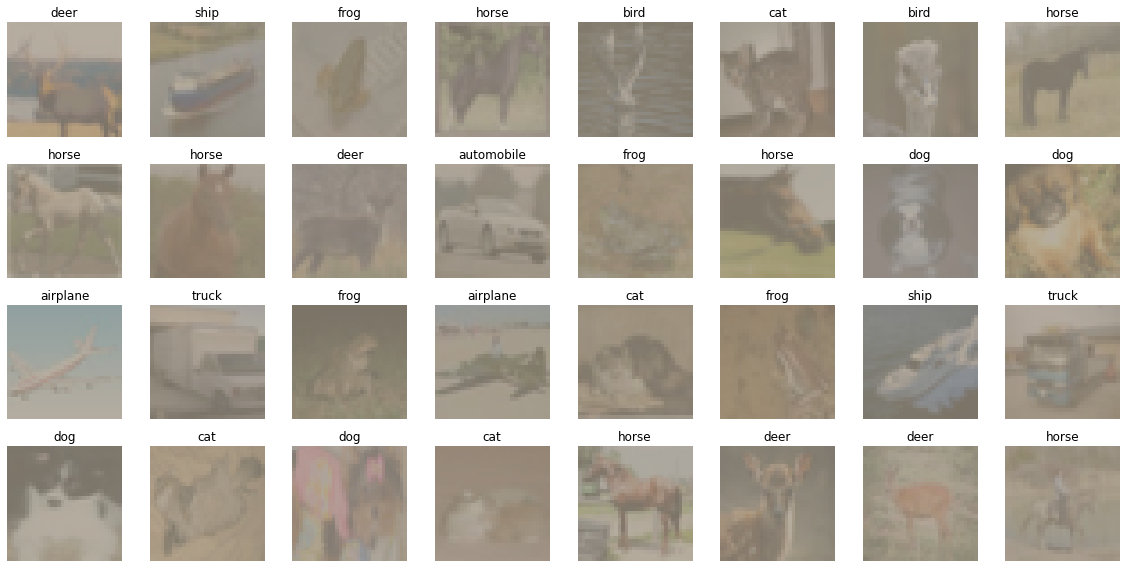

In [ ]:
# Get a batch of training data and displaying it
class_names = train_dataset.classes
inputs, classes = next(iter(train_loader))
titles = [class_names[x] for x in classes]

Helpers().show_grid(inputs, titles=titles)

# Convolutional VAE

In [ ]:
class ConvolutionalVAE(nn.Module):
    def __init__(self):
        super(ConvolutionalVAE, self).__init__()
        self.encoding_layer = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1),
            nn.ReLU()
        )
        self.linear_encoder = nn.Linear(in_features=1024, out_features=1024)

        self.mu_linear = nn.Linear(in_features=1024, out_features=32)
        self.log_var_linear = nn.Linear(in_features=1024, out_features=32)

        self.decoding_layer = nn.Sequential(
            nn.ConvTranspose2d(in_channels=1024, out_channels=128, kernel_size=5, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=5, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=5, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(in_channels=32, out_channels=3, kernel_size=6, stride=2, padding=1),
            nn.Sigmoid()
        )
        self.linear_decoder = nn.Linear(in_features=32, out_features=1024)

    def reparameterize(self, mu, log_var):

        std = torch.exp(0.5*log_var)
        eps = torch.rand_like(std)
        z = mu + std * eps

        return z

    def encoder(self, image):

        encode = self.encoding_layer(image)
        # print(f"encoder encode shape {encode.shape}")
        encode = self.linear_encoder(encode.view(image.size(0), -1))
        # print(f"encoder encode after shape {encode.shape}")

        return encode

    def decoder(self, z):

        decode = self.linear_decoder(z)
        # print(f"decode shape {decode.shape}")
        decode = decode.view(decode.size(0), 1024, 1, 1)
        # print(f"decode view shape {decode.shape}")
        decode = self.decoding_layer(decode)

        return decode

    def forward(self, image):
        # print(f"image shape {image.shape}")

        encode = self.encoder(image)
        # print(f"encode shape {encode.shape}")
        mu = self.mu_linear(encode)
        # print(f"mu shape {mu.shape}")
        logvar = self.log_var_linear(encode)
        # print(f"logvar shape {logvar.shape}")

        z = self.reparameterize(mu, logvar)
        # print(f"Z SHAPE {z.shape}")

        decode = self.decoder(z)
        # print(f"decode after shape {decode.shape}")

        return decode, z, mu, logvar

In [ ]:
ConvolutionalVAE_model = move_to_device(ConvolutionalVAE(), device)
loss_function = Helpers().vae_loss_function
optimizer = torch.optim.Adam(ConvolutionalVAE_model.parameters(), lr=3e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, patience=5, factor=0.1, verbose=True)
epoch = 20

model_fit = Train_model(ConvolutionalVAE_model,
                        loss_function,
                        optimizer,
                        scheduler,
                        test_data_loader,
                        train_data_loader,
                        epochs=epoch)

torch.cuda.empty_cache()
epochs, train_loss, val_loss = model_fit.model_fit()

Training started


epochs: 0
Epoch 1/20:
    Train loss: 1939.67
    Val loss: 1849.87


epochs: 1


KeyboardInterrupt: ignored

In [ ]:
ConvolutionalVAE_model = move_to_device(ConvolutionalVAE(), device)
loss_function = Helpers().vae_loss_function
optimizer = torch.optim.Adam(ConvolutionalVAE_model.parameters(), lr=3e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, patience=5, factor=0.1, verbose=True)
epoch = 20

model_fit = Train_model(ConvolutionalVAE_model,
                        loss_function,
                        optimizer,
                        scheduler,
                        test_data_loader,
                        train_data_loader,
                        epochs=epoch)

torch.cuda.empty_cache()
epochs, train_loss, val_loss = model_fit.model_fit()

Training started


epochs: 0
Epoch 1/20:
    Train loss: 1.3984321324653085e+24
    Val loss: 102521.16




RuntimeError: ignored

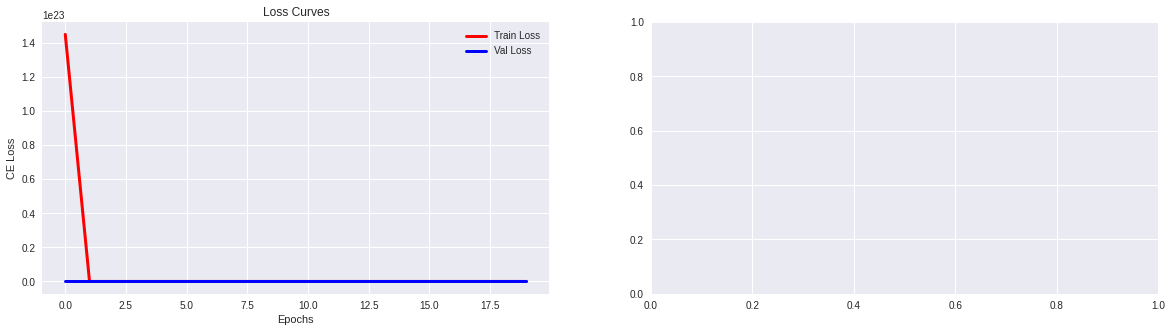

In [ ]:
Helpers().plot_the_curves(epochs, train_loss, val_loss)

# FC VAE

In [ ]:
def get_act(act_name):
    """ Gettign activation given name """
    assert act_name in ["ReLU", "Sigmoid", "Tanh"]
    activation = getattr(nn, act_name)
    return activation()

In [ ]:
class VanillaVAE(nn.Module):
    """
    Implementation of a fully connect autoencoder for 
    denoising  MNIST images
    """
    
    def __init__(self, in_size=(1,32,32), sizes=[1024, 128, 10], act="ReLU"):
        """ Model initlaizer """
        assert np.prod(in_size) == sizes[0]
        super().__init__()
        
        self.in_size = in_size
        self.sizes = sizes
        self.activation = get_act(act) 
        
        self.encoder = self._make_encoder()
        self.decoder = self._make_decoder()
        self.fc_mu = nn.Linear(sizes[-2], sizes[-1])
        self.fc_sigma = nn.Linear(sizes[-2], sizes[-1])
        return
        
    def _make_encoder(self):
        """ Defining encoder """
        layers = [nn.Flatten()]
        
        # adding fc+act+drop for each layer
        for i in range(len(self.sizes)-2):
            layers.append( nn.Linear(in_features=self.sizes[i], out_features=self.sizes[i+1]) )
            layers.append( self.activation )
                
        # replacing last act and dropout with sigmoid
        encoder = nn.Sequential(*layers)
        return encoder
    
    def _make_decoder(self):
        """ Defining decoder """
        layers = []
        
        # adding fc+act+drop for each layer
        for i in range(1, len(self.sizes)):
            layers.append( nn.Linear(in_features=self.sizes[-i], out_features=self.sizes[-i-1]) )
            layers.append( self.activation )
                
        # replacing last act and dropout with sigmoid
        layers = layers[:-1] + [nn.Sigmoid()]
        decoder = nn.Sequential(*layers)
        return decoder
        
    
    def reparameterize(self, mu, log_var):
        """ Reparametrization trick"""
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)  # random sampling happens here
        z = mu + std * eps
        return z

    
    def forward(self, x):
        """ Forward pass """
        
        # encoding and computng statistics
        x_enc = self.encoder(x)
        mu = self.fc_mu(x_enc)
        log_var = self.fc_sigma(x_enc)
        
        # reparametrization trick
        z = self.reparameterize(mu, log_var)
        
        # decoding
        x_hat_flat = self.decoder(z)
        x_hat = x_hat_flat.view(-1, *self.in_size)
        
        return x_hat, z, mu, log_var

In [ ]:
VanillaVAE_model = move_to_device(VanillaVAE(in_size=(3,32,32), sizes=[3072, 256, 128, 64, 3], act="ReLU"), device)
loss_function = Helpers().vae_loss_function
optimizer = torch.optim.Adam(VanillaVAE_model.parameters(), lr=3e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, patience=5, factor=0.1, verbose=True)
epoch = 20

model_fit = Train_model(VanillaVAE_model,
                        loss_function,
                        optimizer,
                        scheduler,
                        test_data_loader,
                        train_data_loader,
                        epochs=epoch)

torch.cuda.empty_cache()
epochs, train_loss, val_loss = model_fit.model_fit()

Training started


Epoch 1/20:
    Train loss: 1965.72
    Val loss: 1937.42


Epoch 6/20:
    Train loss: 1927.81
    Val loss: 1929.51


Epoch 11/20:
    Train loss: 1926.81
    Val loss: 1925.68


Epoch 16/20:
    Train loss: 1927.07
    Val loss: 1932.13


Epoch    17: reducing learning rate of group 0 to 3.0000e-04.
Epoch 20/20:
    Train loss: 1920.98
    Val loss: 1923.72


Training completed!


# comaprison

From above we can see the performances of both FC-VAE and Conv-VAE models. As can be seen, FC-VAE works better compared to Conv-VAE. I suspet the configurations of convolution layers in the encoder and decoder layers of autoencoder. But we cannot comment which works better based on this particular configuration.

# Latent space for clustering and classification

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

In [ ]:
class Classifier(nn.Module):
    def __init__(self, encodded_data_size):
        super(Classifier, self).__init__()
        self.encodded_data_size = encodded_data_size
        self.classification_layer = nn.Sequential(
            nn.Linear(in_features=32, out_features=32),
            nn.LeakyReLU(),
            nn.Linear(in_features=32, out_features=10)
        )

    def forward(self, image):
        # print(f"image size {image.shape}")
        output = self.classification_layer(image)
        return output

In [ ]:
class Classification_and_Clustering(object):
    def __init__(self,
                 classification_model,
                 VAE_model,
                 loss_function,
                 optimizer,
                 val_data_loader,
                 train_data_loader,
                 epochs=10):

        super(Classification_and_Clustering, self).__init__()
        self.classification_model = classification_model
        self.VAE_model = VAE_model
        self.loss_function = loss_function
        self.optimizer = optimizer
        self.val_data_loader = val_data_loader
        self.train_data_loader = train_data_loader
        self.epochs = epochs

    def train(self, encoded_data, target_label):

        self.classification_model.train()

        self.optimizer.zero_grad()
        output = self.classification_model(encoded_data)
        loss = self.loss_function(output, target_label)
        loss.backward()
        self.optimizer.step()
        train_acc = Helpers().accuracy(target_label, output)

        return loss.item(), train_acc

    def evaluate(self, data_loader):

        val_loss = []
        val_accu = []

        self.classification_model.eval()
        self.VAE_model.eval()
        with torch.no_grad():
            for image, label in data_loader:
                _, encoded_data, _, _ = self.VAE_model(image)
                output = self.classification_model(encoded_data)
                val_loss.append(self.loss_function(output, label))
                val_accu.append(Helpers().accuracy(label, output))

        val_loss = torch.stack(val_loss).mean()
        val_accu = torch.stack(val_accu).mean()

        return val_loss.item(), val_accu.item()

    def clustering(self, data_loader):

        flattened_images = []
        latent_space = [] 
        labels = []

        with torch.no_grad():
            self.VAE_model.train()
            for image, label in data_loader:
                _, encoded_data, _, _ = self.VAE_model(image)
                flattened_images.append(image.cpu().view(image.shape[0], -1))
                latent_space.append(encoded_data.cpu())
                labels.append(label.cpu())

        flattened_images = np.concatenate(flattened_images)
        latent_space = np.concatenate(latent_space)
        labels = np.concatenate(labels)

        return flattened_images, latent_space, labels


    def model_fit(self):

        val_loss = []
        val_accu = []
        train_loss = []
        train_accu = []

        epochs = []

        print(f"Training started")
        print(f"\n")

        for i in range(self.epochs):
            train_loss_iter = []
            train_accu_iter = []
            for image, label in self.train_data_loader:

                _, encoded_data, _, _ = self.VAE_model(image)
                # print(f"encoded data size {encoded_data.shape}")
                loss, accu = self.train(encoded_data, label)
                train_loss_iter.append(loss)
                train_accu_iter.append(accu)

            v_loss, v_accu = self.evaluate(self.val_data_loader)
            val_loss.append(v_loss)
            val_accu.append(v_accu)
            epochs.append(i)

            train_loss.append(np.mean(train_loss_iter))
            train_accu.append(np.mean(train_accu_iter))

            if i % 10 == 0 or i == self.epochs-1:
                print(f"Epoch {i+1}/{self.epochs}:")
                print(f"    Train loss: {np.round(np.mean(train_loss_iter), 2)}")
                print(f"    Train accuracy: {np.round(np.mean(train_accu_iter), 2)*100}%")
                print(f"    Val loss: {np.round(v_loss, 2)}")
                print(f"    Val accuracy: {np.round(v_accu, 2)*100}%")
                print(f"\n")

        print(f"Training completed!")

        return epochs, train_loss, train_accu, val_loss, val_accu

In [ ]:
Classifier_model = move_to_device(Classifier(64*32), device)
ConvolutionalVAE_model = move_to_device(ConvolutionalVAE(), device)
loss_function = Functions.cross_entropy
optimizer = torch.optim.Adam(Classifier_model.parameters(), lr=0.01)
epoch = 50


model_fit = Classification_and_Clustering(Classifier_model,
                                          ConvolutionalVAE_model,
                                          loss_function,
                                          optimizer,
                                          test_data_loader,
                                          train_data_loader,
                                          epochs=epoch)

In [ ]:
torch.cuda.empty_cache()
epochs, train_loss, train_accu, val_loss, val_accu = model_fit.model_fit()

Training started


Epoch 1/50:
    Train loss: 2.3
    Train accuracy: 10.999999940395355%
    Val loss: 2.3
    Val accuracy: 11.0%


Epoch 11/50:
    Train loss: 2.28
    Train accuracy: 12.999999523162842%
    Val loss: 2.29
    Val accuracy: 13.0%


Epoch 21/50:
    Train loss: 2.28
    Train accuracy: 12.999999523162842%
    Val loss: 2.28
    Val accuracy: 13.0%


Epoch 31/50:
    Train loss: 2.28
    Train accuracy: 12.999999523162842%
    Val loss: 2.28
    Val accuracy: 14.000000000000002%


Epoch 41/50:
    Train loss: 2.28
    Train accuracy: 12.999999523162842%
    Val loss: 2.28
    Val accuracy: 13.0%


Epoch 50/50:
    Train loss: 2.28
    Train accuracy: 12.999999523162842%
    Val loss: 2.28
    Val accuracy: 13.0%


Training completed!


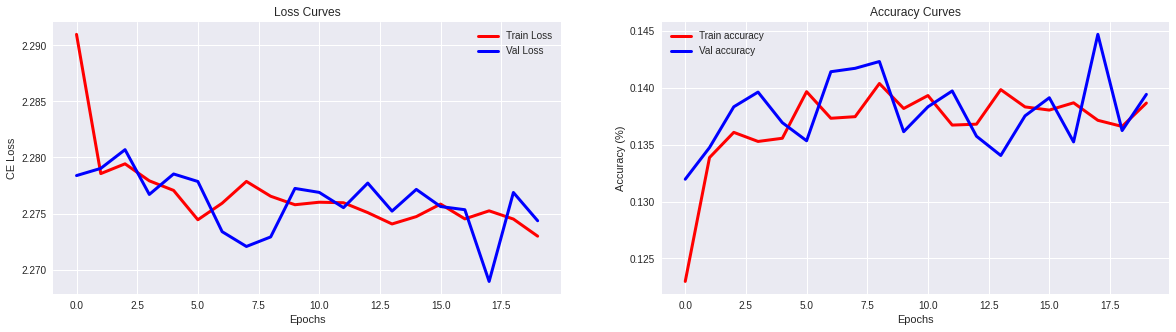

In [ ]:
def plot_the_curves(epochs, train_loss, train_accu, val_loss, val_accu):

    plt.style.use('seaborn')
    fig, ax = plt.subplots(1,2)
    fig.set_size_inches(20,5)

    ax[0].plot(epochs, train_loss, c="red", label="Train Loss", linewidth=3)
    ax[0].plot(epochs, val_loss, c="blue", label="Val Loss", linewidth=3)
    ax[0].legend(loc="best")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("CE Loss")
    ax[0].set_title("Loss Curves")

    ax[1].plot(epochs, train_accu, c="red", label="Train accuracy", linewidth=3)
    ax[1].plot(epochs, val_accu, c="blue", label="Val accuracy", linewidth=3)
    ax[1].legend(loc="best")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Accuracy (%)")
    ax[1].set_title(f"Accuracy Curves")

    plt.show()

plot_the_curves(epochs, train_loss, train_accu, val_loss, val_accu)

From above we can see that accuracies are too low for classification of various object classes of CIFAR-10 dataset. This may be because of the latent space clarity. I suspect the encoder and decoder configurations for encoding the CIFAR-10 data.

In [ ]:
COLORS = ['r', 'b', 'g', 'y', 'purple', 'orange', 'k', 'brown', 'grey',
          'c', "gold", "fuchsia", "lime", "darkred", "tomato", "navy"]

def display_projections(points, labels, ax=None, legend=None):
    """ Displaying low-dimensional data projections """
    
    legend = [f"Class {l}" for l in np.unique(labels)] if legend is None else legend
    if(ax is None):
        _, ax = plt.subplots(1,1,figsize=(12,6))
    
    for i,l in enumerate(np.unique(labels)):
        idx = np.where(l==labels)

        ax.scatter(points[idx, 0], points[idx, 1], label=legend[int(l)], c=COLORS[i])
    ax.legend(loc="best")

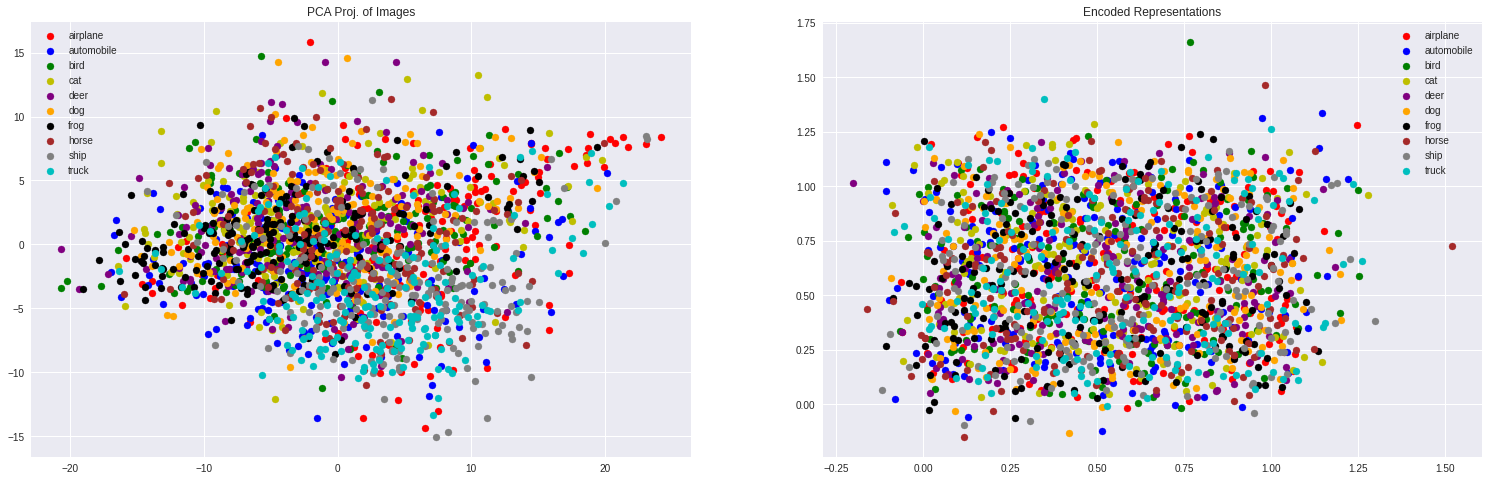

In [ ]:
flattened_images, latent_space, labels = model_fit.clustering(test_data_loader)

pca_imgs = PCA(n_components=2).fit_transform(flattened_images)

N = 2000
fig,ax = plt.subplots(1,2,figsize=(26,8))
display_projections(pca_imgs[:N], labels[:N], ax=ax[0], legend=test_dataset.classes)
ax[0].set_title("PCA Proj. of Images")
display_projections(latent_space[:N], labels[:N], ax=ax[1], legend=test_dataset.classes)
ax[1].set_title("Encoded Representations")
plt.show()

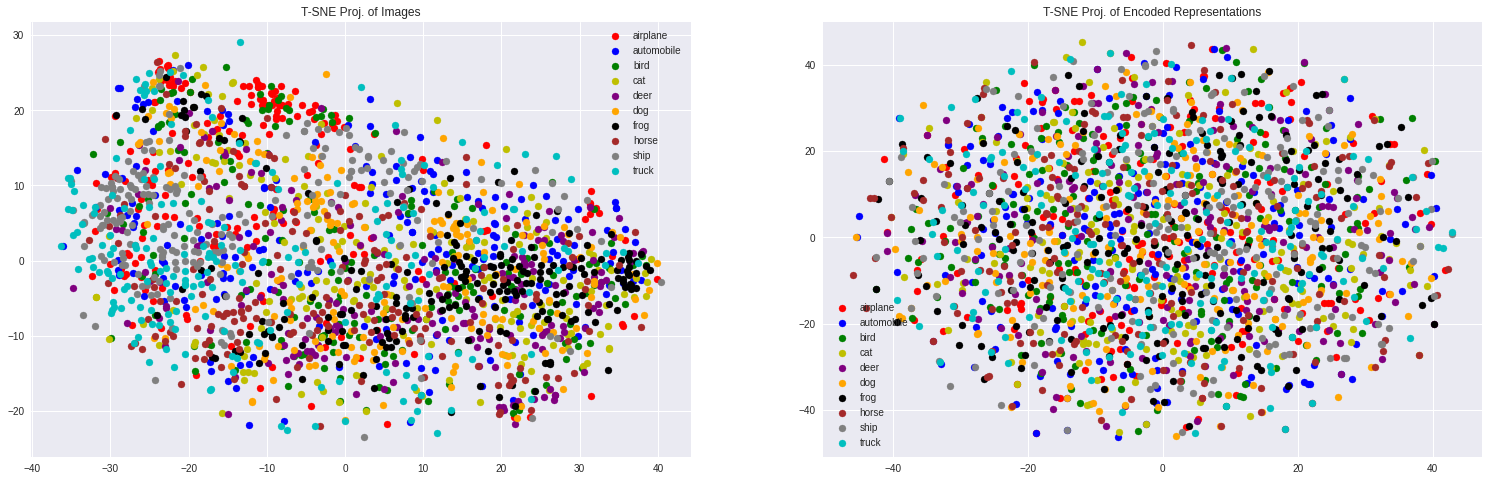

In [ ]:
N = 2000
tsne_imgs = TSNE(n_components=2).fit_transform(flattened_images[:N])
tsne_latents = TSNE(n_components=2).fit_transform(latent_space[:N])

fig,ax = plt.subplots(1,2,figsize=(26,8))
display_projections(tsne_imgs[:N], labels[:N], ax=ax[0], legend=test_dataset.classes)
ax[0].set_title("T-SNE Proj. of Images")
display_projections(tsne_latents[:N], labels[:N], ax=ax[1], legend=test_dataset.classes)
ax[1].set_title("T-SNE Proj. of Encoded Representations")
plt.show()

# Latent space and interpolations


In [ ]:
@torch.no_grad()
def plot_reconstructed(model, xrange=(-3, 3), yrange=(-2, 2), N=12):
    """
    Sampling equispaced points from the latent space givent the xange and yrange, 
    decoding latents and visualizing distribution of the space
    """
    SIZE = 32
    grid = np.empty((N*SIZE, N*SIZE))
    
    for i, y in enumerate(np.linspace(*yrange, N)):
        for j, x in enumerate(np.linspace(*xrange, N)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = model.decoder(z).cpu()
            x_hat = x_hat.view(3,32,32)
            
            grid[(N-1-i)*SIZE:(N-i)*SIZE, j*SIZE:(j+1)*SIZE] = x_hat[2]
           
    plt.figure(figsize=(12,20))
    plt.imshow(grid, extent=[*yrange, *xrange], cmap="gray")
    plt.axis("off")

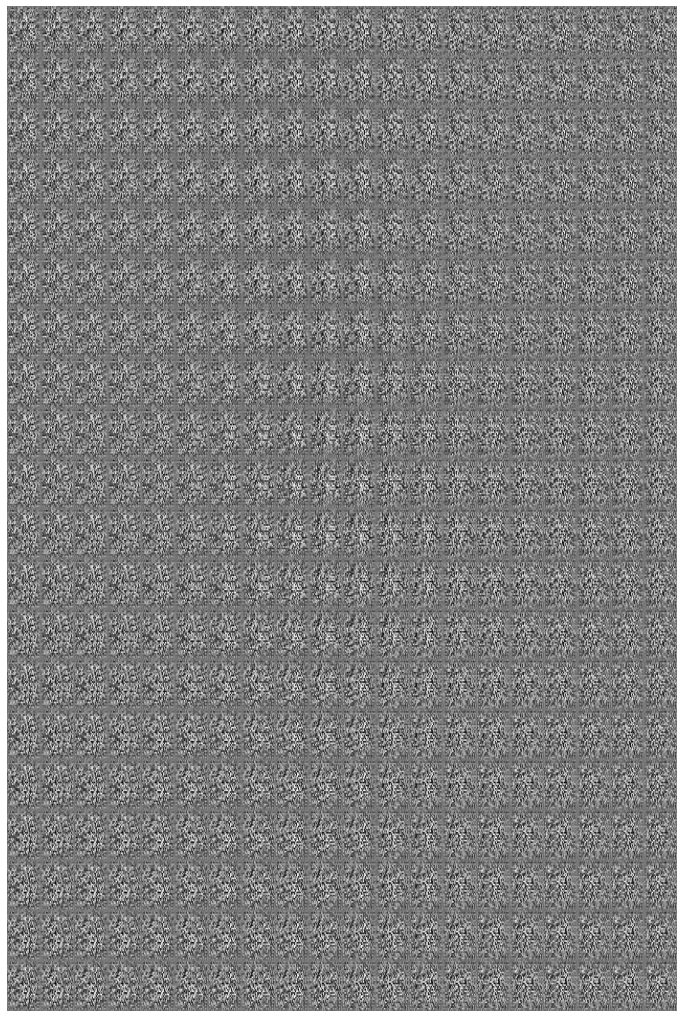

In [ ]:
plot_reconstructed(ConvolutionalVAE_model, xrange=(-3, 3), yrange=(-2, 2), N=20)

In [ ]:
img1 = test_dataset[0][0]
img2 = test_dataset[13][0]

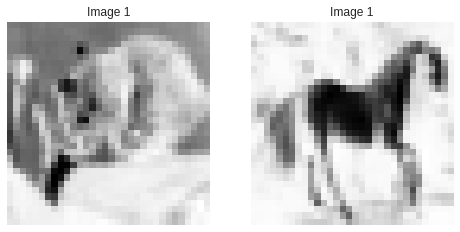

In [ ]:
plt.subplot(1,2,1)
plt.imshow(img1[0])
plt.axis("off")
plt.title(f"Image 1")
plt.subplot(1,2,2)
plt.imshow(img2[0])
plt.axis("off")
plt.title(f"Image 1")
plt.show()

In [ ]:
with torch.no_grad():
    encoded = ConvolutionalVAE_model.encoder(torch.stack([img1, img2]).to(device))
    mus, log_var = ConvolutionalVAE_model.mu_linear(encoded), ConvolutionalVAE_model.log_var_linear(encoded)
std = torch.exp(0.5*log_var)
latents = mus + std
latent1, latent2 = latents[0], latents[1]

In [ ]:
@torch.no_grad()
def sample_interpolation(model, p1, p2, N=15):
    """ Sampling N points from the line that connects p1 and p2 """
    
    z = torch.stack([p1 * t + p2 * (1-t) for t in torch.linspace(0, 1, N).to(device)])
    decoded = model.decoder(z)
    decoded_imgs = decoded.cpu().view(-1,32,32)
    return decoded_imgs

In [ ]:
decoded_imgs = sample_interpolation(ConvolutionalVAE_model, latent2, latent1, N=12)

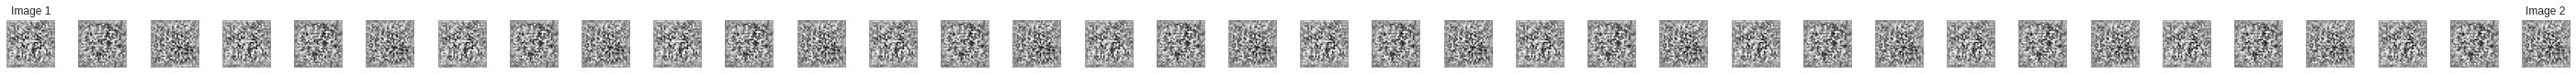

In [ ]:
fig, ax = plt.subplots(1, len(decoded_imgs), figsize=(50,6))
for i,img in enumerate(decoded_imgs):
    ax[i].imshow(img)
    ax[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

plt.subplots_adjust(wspace=0.5, hspace=0.5)
ax[0].set_title("Image 1")
ax[-1].set_title("Image 2")
plt.show()

To be honest, I am not able to differentiate between these various interpolations of the latent space.